# [Statoil/C-CORE Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)
- Ship or iceberg, can you decide from space?

## Overview

### Description
漂流氷山は、カナダの東海岸の沖合などの地域での航行や活動に対する脅威を示しています。

現在、多くの機関や企業が空中偵察と陸上支援を使用して、環境条件を監視し、氷山のリスクを評価しています。しかし、特に荒天のある遠隔地では、これらの方法は実行できず、実行可能な監視オプションは衛星経由のみです。

世界中で事業を展開している国際的なエネルギー企業であるStatoilは、C-COREなどの企業と緊密に連携してきました。 C-COREは30年以上にわたって衛星データを使用しており、コンピュータビジョンベースの監視システムを構築しています。操業の安全性と効率性を維持するために、Statoilは、機械学習を使用して、脅威となる氷山をより正確に検出し、差別化する方法について、新たな視点を得ることに関心を持っています。

このコンテストでは、リモートで検出されたターゲットが船か氷山かを自動的に識別するアルゴリズムを構築する必要があります。行われた改善は、安全な労働条件を維持するためのコストを下げるのに役立ちます。

<div>
<img src="https://i.imgur.com/q7uAjTM.jpg" width="300" height="300" align="left"/>
</div>

### Evaluation
テストセットの各IDについて、画像に氷山（0から1の間の数）が含まれる確率を予測する必要があります。ファイルにはヘッダーが含まれ、次の形式である必要があります。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
%matplotlib inline

In [2]:
df_train = pd.read_json('/Users/ikeda/Desktop/machine_learnings/Kaggle/Statoil:C-CORE_IcebergClassifierChallenge/statoil-iceberg-classifier-challenge/train.json')
df_test = pd.read_json('/Users/ikeda/Desktop/machine_learnings/Kaggle/Statoil:C-CORE_IcebergClassifierChallenge/statoil-iceberg-classifier-challenge/test.json')
df_train.head()

id                                             band_1  \
0  dfd5f913  [-27.878360999999998, -27.15416, -28.668615, -...   
1  e25388fd  [-12.242375, -14.920304999999999, -14.920363, ...   
2  58b2aaa0  [-24.603676, -24.603714, -24.871029, -23.15277...   
3  4cfc3a18  [-22.454607, -23.082819, -23.998013, -23.99805...   
4  271f93f4  [-26.006956, -23.164886, -23.164886, -26.89116...   

                                              band_2 inc_angle  is_iceberg  
0  [-27.154118, -29.537888, -31.0306, -32.190483,...   43.9239           0  
1  [-31.506321, -27.984554, -26.645678, -23.76760...   38.1562           0  
2  [-24.870956, -24.092632, -20.653963, -19.41104...   45.2859           1  
3  [-27.889421, -27.519794, -27.165262, -29.10350...   43.8306           0  
4  [-27.206915, -30.259186, -30.259186, -23.16495...   35.6256           0

### Data
- id
    - 画像のID
- band_1, band_2
    - 平坦化された画像データ。 各バンドのリストには75x75ピクセル値があるため、リストには5625個の要素があります。 これらの値は物理的な意味を持つため、画像ファイルでは通常の非負の整数ではないことに注意してください。これらは浮動小数点数であり、単位はdBです。 バンド1とバンド2は、特定の入射角で異なる偏光から生成されるレーダー後方散乱によって特徴付けられる信号です。 偏波は、HH（水平方向に送信/受信）およびHV（水平方向に送信し、垂直方向に受信）に対応しています。 衛星画像の背景については、こちらをご覧ください。
- inc_angle
    - 画像が取得された入射角。 このフィールドには「na」とマークされた欠落データがあり、「na」の入射角を持つ画像はすべて漏れを防ぐためにトレーニングデータに含まれていることに注意してください。
- is_iceberg
    - ターゲット変数。氷山の場合は1に設定され、船の場合は0に設定されます。 このフィールドはtrain.jsonにのみ存在します。

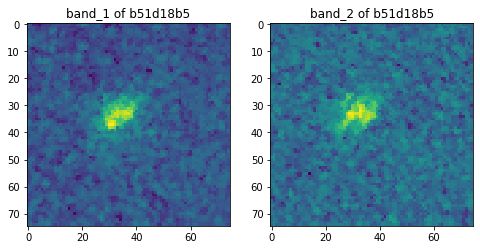

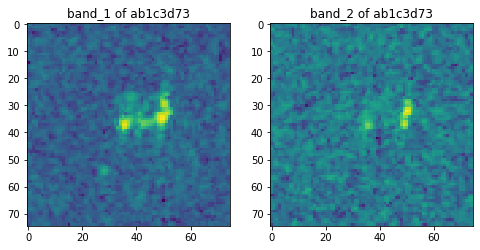

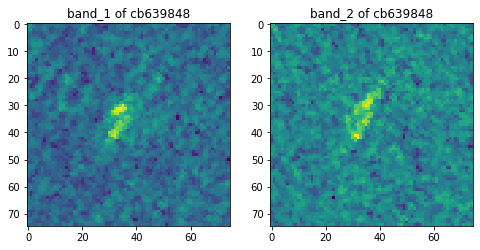

In [3]:
# randomに３つ画像表示
for i in np.random.randint(0, len(df_train), 3):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(np.array(df_train['band_1'][i]).reshape(75, -1))
    ax.set_title('band_1 of {}'.format(df_train['id'][i]))
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.array(df_train['band_2'][i]).reshape(75, -1))
    ax.set_title('band_2 of {}'.format(df_train['id'][i]))
    plt.show()

## EDA

### [Exploration & Transforming Images in Python](https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python)

In [4]:
train = deepcopy(df_train)
# 例外はNanで返し、数値変換する
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

#### Plotting the Statistics
これで、これらの変数のヒストグラムを作成できます。両方のクラスのヒストグラムを作成して、違いがあるかどうかを確認します。

In [5]:
# band_1, band_2　の　statsを取得
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]

    return train
train = get_stats(train,1)
train = get_stats(train,2)

In [6]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

/Users/ikeda/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/ikeda/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


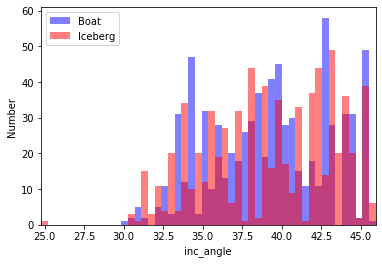

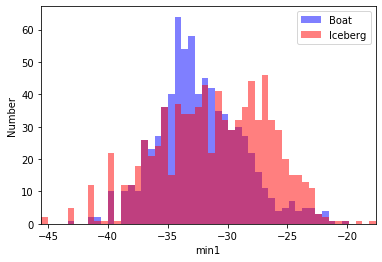

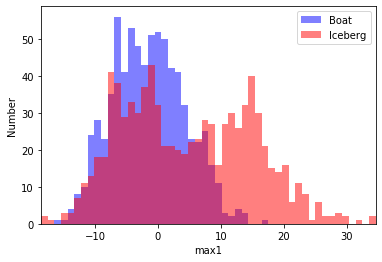

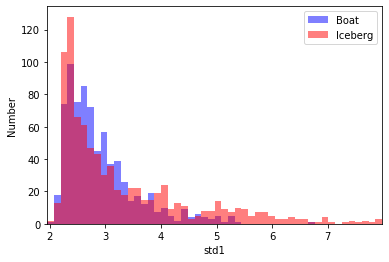

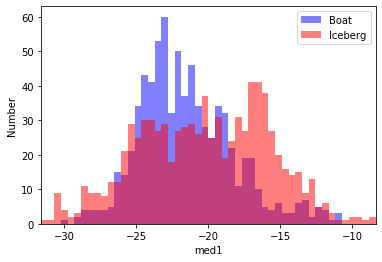

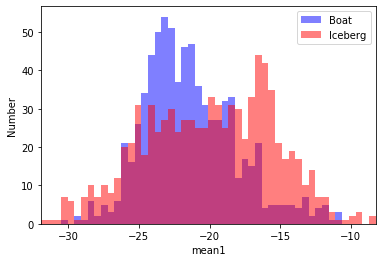

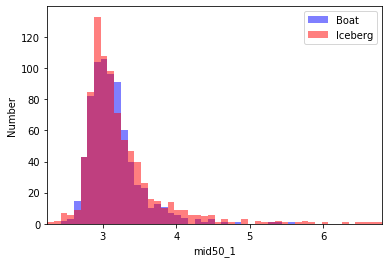

In [7]:
for col in ['inc_angle','min1','max1','std1','med1','mean1','mid50_1']:
    plot_var(col)

最初のバンドについては、いくつかの大きな違いがあることがわかります。 中央の50％の範囲はどちらもほぼ同じサイズですが、最小値、最大値、標準偏差、中央値、および平均値はすべて、一部の値の範囲で顕著な違いを示しています。 明らかに、これらの基本的な変数は、私たちが測定しようとしているものに対してある程度の感度を持っているようです。 たとえば、氷山が船よりもはるかに大きく、したがってより多くのピクセルをカバーしている場合、これが予想されます。

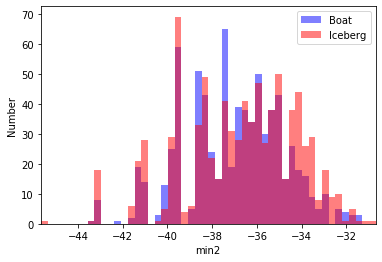

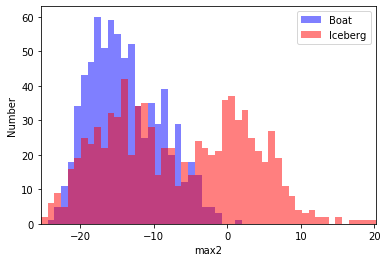

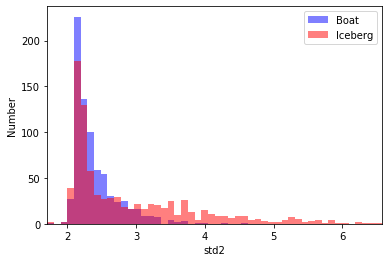

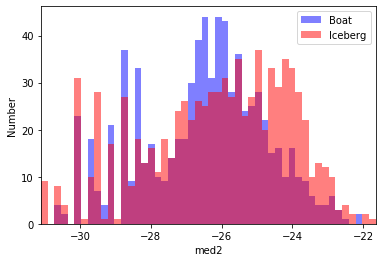

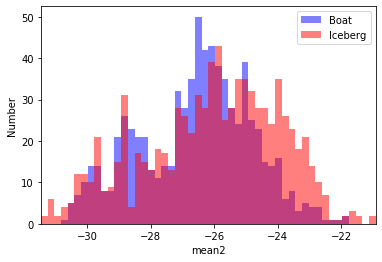

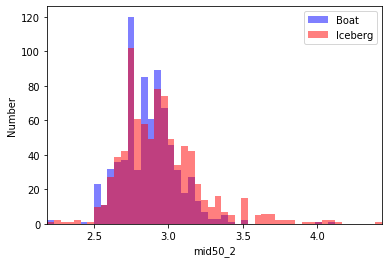

In [8]:
for col in ['min2','max2','std2','med2','mean2','mid50_2']:
    plot_var(col)

2番目のバンドでも同様の結果が得られます。

#### Correlations Between Features
これらの変数に用途があることがわかったので、それらの間の相関関係を確認する必要があります。 このため、相関行列をプロットします。 また、変数の各ペアの散布図を見るとよいでしょう（これはSeabornで簡単に実行できます）が、ここではそれを行いません。

In [9]:
train_stats = train.drop(['id','is_iceberg','band_1','band_2'],axis=1)

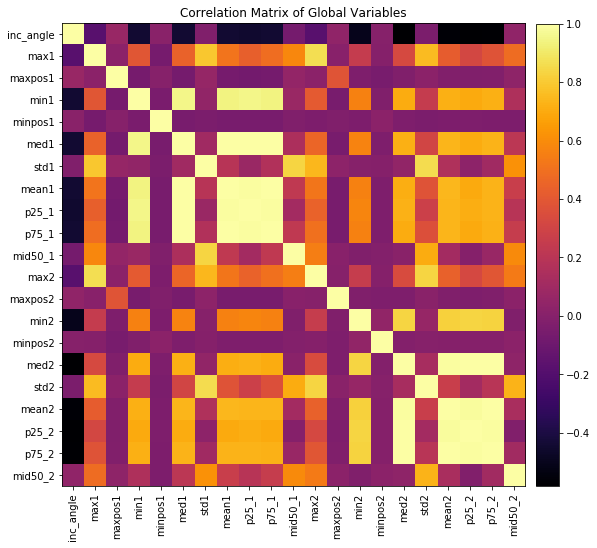

In [10]:
corr = train_stats.corr()
fig = plt.figure(1, figsize=(10,10))
plt.imshow(corr,cmap='inferno')
labels = np.arange(len(train_stats.columns))
plt.xticks(labels,train_stats.columns,rotation=90)
plt.yticks(labels,train_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85,pad=0.02)
plt.show()

一部の変数間には大きな相関関係があることがわかります。 特に、平均値、中央値、25％の信号、および75％の信号はすべて密接に関連しており、ほぼ75％の相関があります。 最小値と最大値は、両方のバンドの最小値と中央値と同様に、バンド1でもかなり強く相関しています。これは、この相関を強制するために信号が何らかの方法でスケーリングされていることを示唆しています。 2つのバンドの間にもいくつかの相関があります。 最後に、バンド2の平均と角度の間に約-0.5の反相関があり、バンド1の相関は弱くなっています。

#### Plotting Some Images
過度の分析を行う前に、いくつかの画像をプロットすることをお勧めします。 このようにして、私たちは自分が見ているものの感覚をつかむことができます。 画像は75 x 75ピクセルで、それぞれ2つのバンドがあります。

In [11]:
icebergs = train[train.is_iceberg==1].sample(n=9,random_state=123)
ships = train[train.is_iceberg==0].sample(n=9,random_state=456)

#### Raw Images
The first set show 9 random icebergs using band 1.

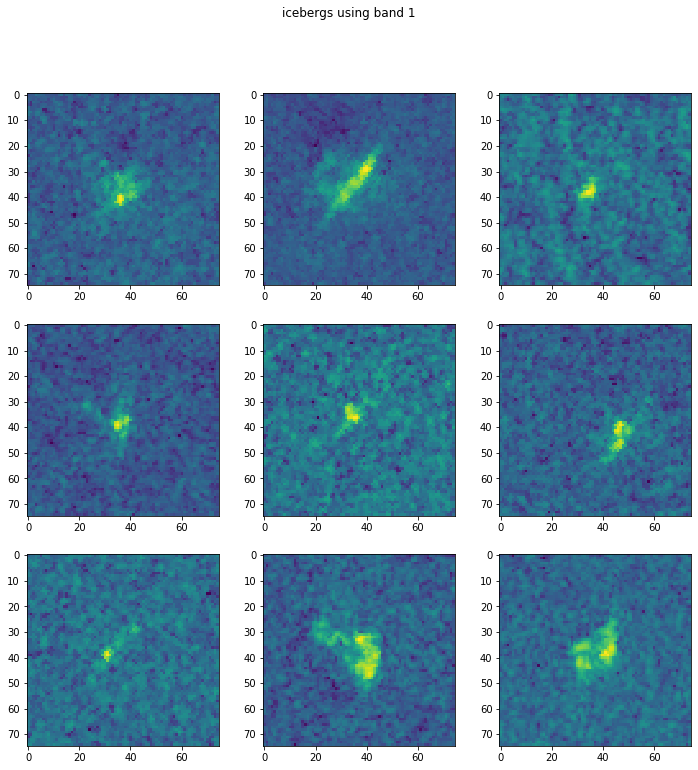

In [12]:
# Plot band_1
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr)
fig.suptitle('icebergs using band 1')
plt.show()

The second set shows ships in band 1.

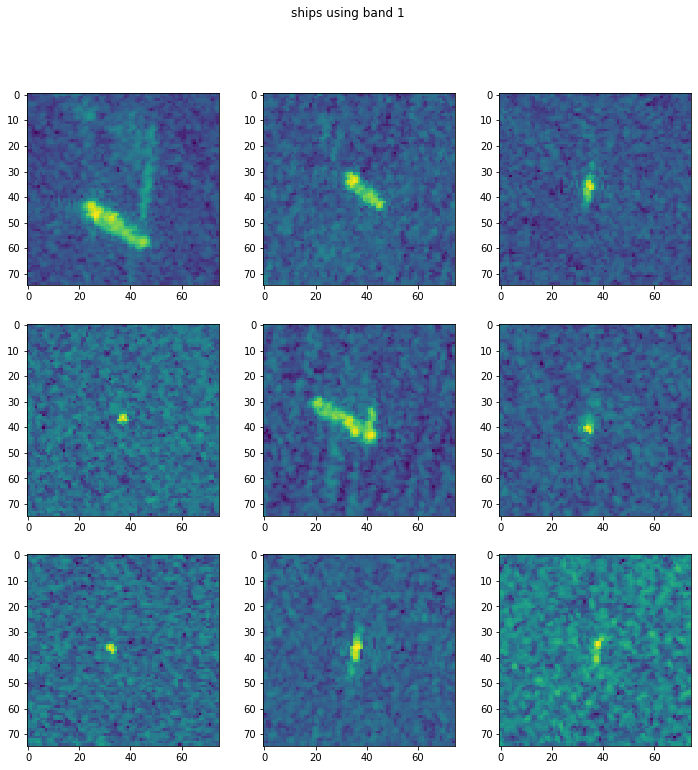

In [13]:
# Plot band_1
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
    ax.imshow(arr)
fig.suptitle('ships using band 1')
plt.show()

The next set show the same set of icebergs in band 2.

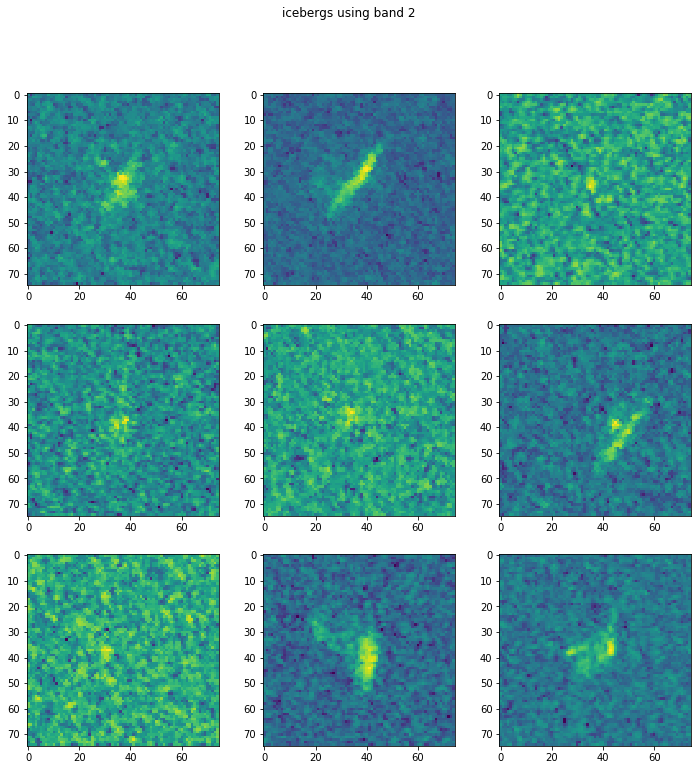

In [14]:
# Plot band_2
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,2]),(75,75))
    ax.imshow(arr)
fig.suptitle('icebergs using band 2')    
plt.show()

Finally, the last set are the same ship images as before, but for band 2.

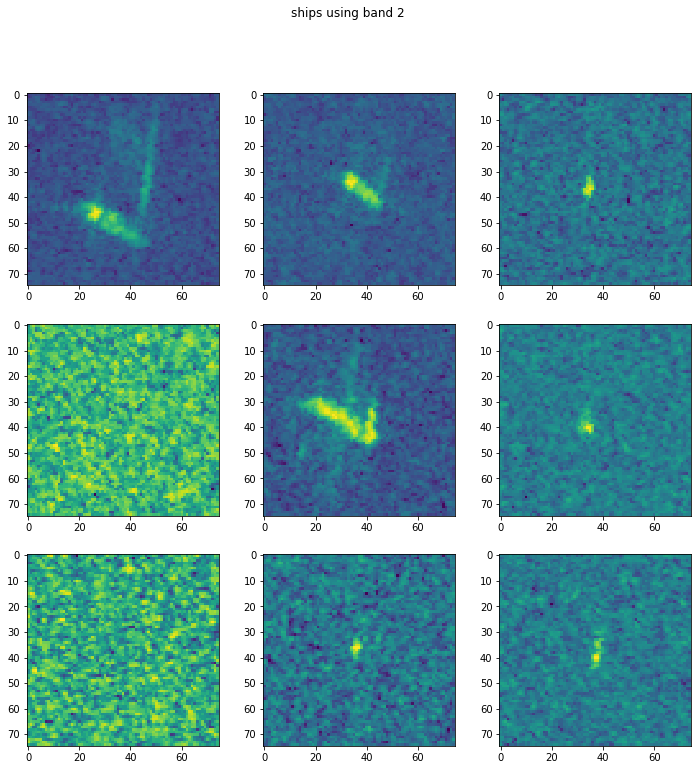

In [15]:
# Plot band_2
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,2]),(75,75))
    ax.imshow(arr)
fig.suptitle('ships using band 2')
plt.show()

したがって、すべてがかなりblobのように見えることがわかります。 また、背景は実際にはランダムなノイズではなく、空間的な相関関係があるようにも見えます。 背景がノイズではなく波のようなものによって支配されている場合、空間相関が明らかに期待されます。 船はより規則的な構造をしており、大きな信号のブロブに顕著な歪度があります。

これらのブロブの一部はノイズより高くありません。最後のセットでは、信号が目で確認することさえできない2つの画像さえあります。そのため、最初に画像を何らかの方法で変換して、 信号と背景。

#### Transforming the Images

FIRフィルターで簡単に定義できるいくつかのタイプの基本変換を見ていきます。 `scipy convolve2d関数は2つの配列のたたみ込み`を実行するため、カーネルを定義するだけで済みます。 ここではカーネルを最適化していないため、カーネルの種類には他にも多くの選択肢があるため、さまざまなオプションを試して、カーネルの機能を確認する必要があります。

In [16]:
from scipy import signal
# kernel
xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
smooth = np.array([[1,1,1],[1,5,1],[1,1,1]])
xder2 = np.array([[-1,2,-1],[-3,6,-3],[-1,2,-1]])
yder2 = np.array([[-1,-3,-1],[2,6,2],[-1,-3,-1]])

* [supporting document](https://github.com/satoshi30/machine_learnings/blob/master/Kaggle/Statoil:C-CORE_IcebergClassifierChallenge/transforming_images_scipy_convolve2d.ipynb)

#### Smoothing
まず、画像をスムージングしてみましょう。 ここでのカーネルは、すべての正の値を持ち、双方向に対称です。

最初に氷山を計画し、次に船を計画します。 これらはすべてバンド1用です。

In [17]:
# kernel
smooth = np.array([[1,1,1],[1,5,1],[1,1,1]])

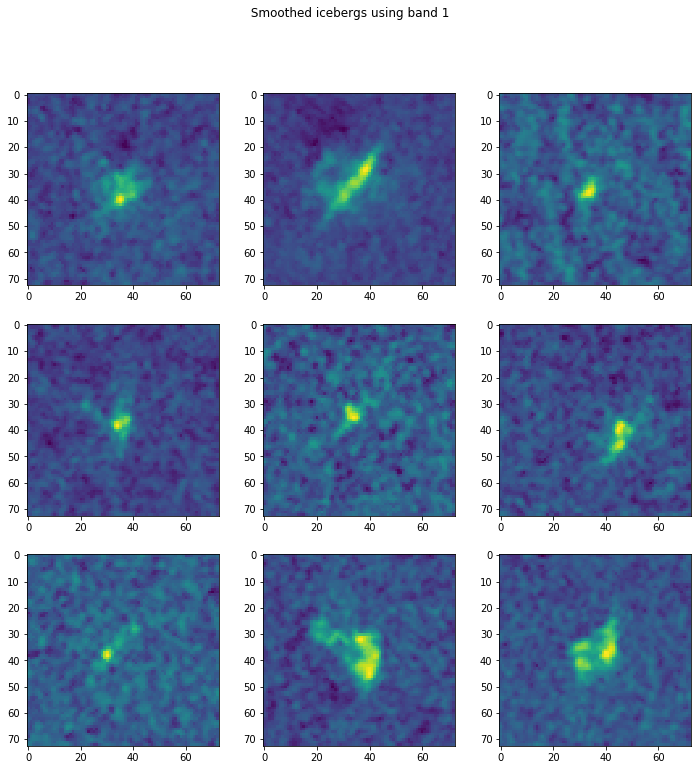

In [18]:
# Plot band_1
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),smooth,mode='valid')
    ax.imshow(arr)
fig.suptitle(' Smoothed icebergs using band 1')
plt.show()

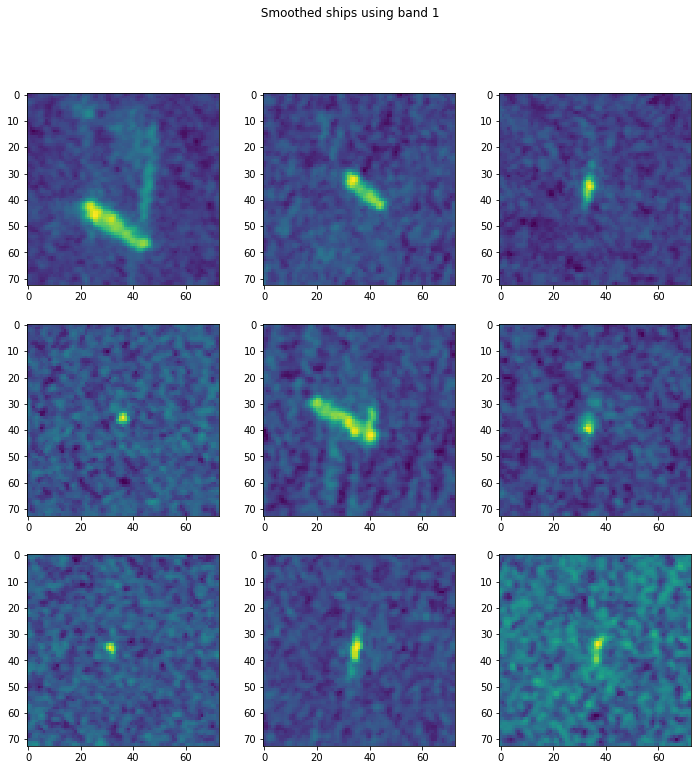

In [19]:
# Plot band_1
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),smooth,mode='valid')
    ax.imshow(arr)
fig.suptitle(' Smoothed ships using band 1')
plt.show()

ご想像のとおり、スムージングは​​機能をぼかします。ただし、明るい領域と暗い領域のコントラストも強調されるため、クラスター/ピークファインダーにいくつかのクラスターをシードする場合に使用すると非常に便利です。

#### Derivative with Respect to X

In [20]:
# kernel
xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

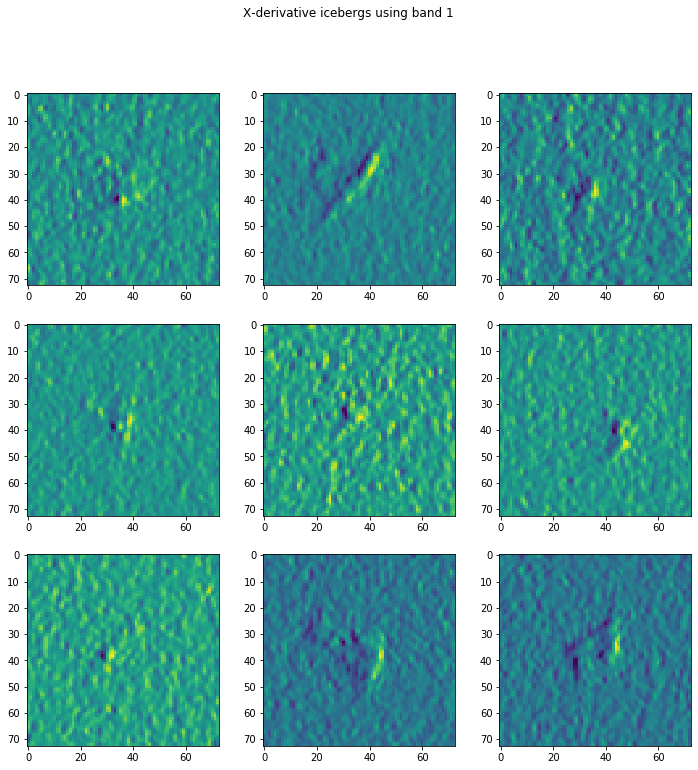

In [21]:
# Plot band_1
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder,mode='valid')
    ax.imshow(arr)
fig.suptitle('X-derivative icebergs using band 1')
plt.show()

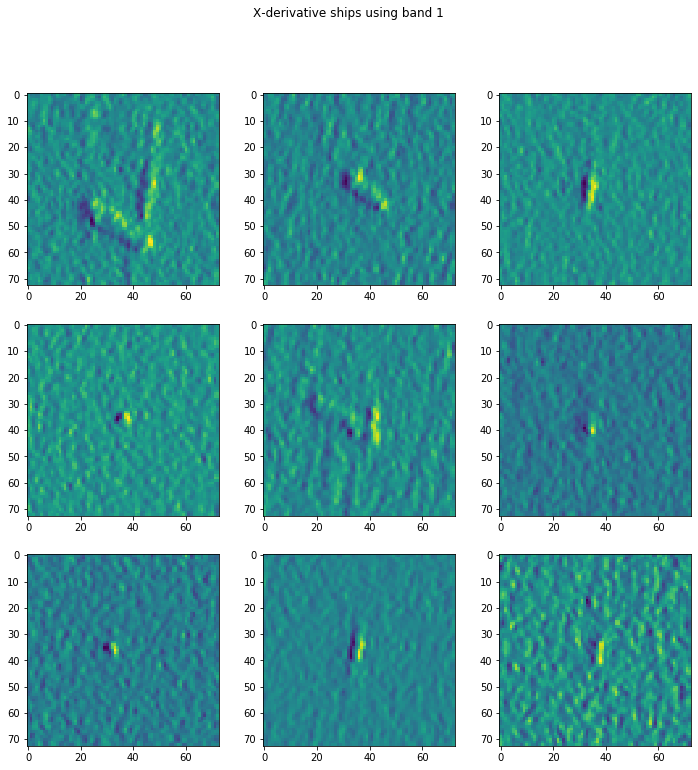

In [22]:
# Plot band_1
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder,mode='valid')
    ax.imshow(arr)
fig.suptitle('X-derivative ships using band 1')
plt.show()

ピークの左側に暗い領域があり、右側に明るい領域があることに注意してください。 よく見ると、これらのすべての変換で位置が変更されている可能性があります。 これは、アレイをゼロパッドしないことを選択したためです。 結果の変換された配列は、入力よりもわずかに小さくなります。

#### Gradient Magnitude
y導関数の実行方法を確認することも簡単です。 それよりも、勾配の大きさを確認できます。 つまり、xとyの導関数を各位置の勾配ベクトルとして扱い、各点の大きさを取得します。

[numpy.hypot](https://numpy.org/doc/stable/reference/generated/numpy.hypot.html)

In [23]:
# kernel
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

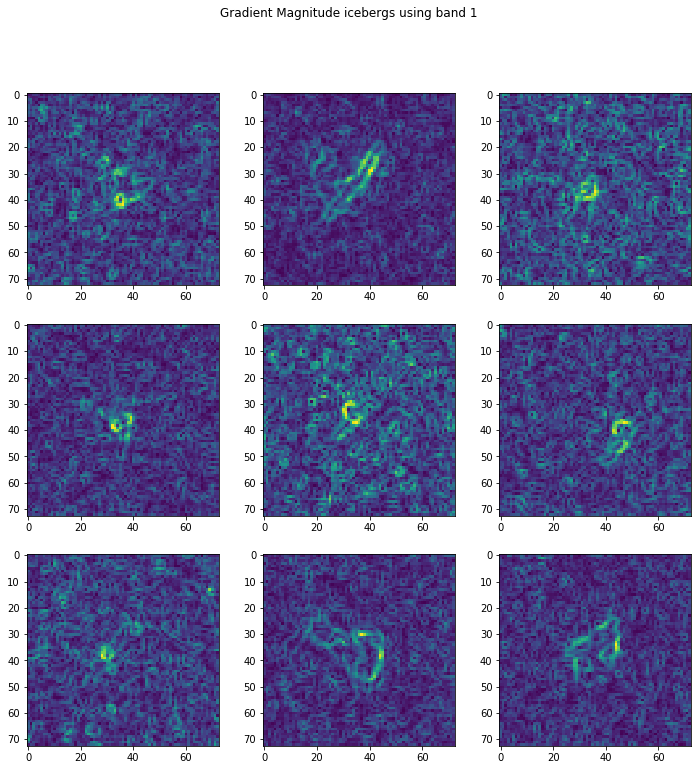

In [24]:
# Plot band_1
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry))
fig.suptitle('Gradient Magnitude icebergs using band 1')
    
plt.show()

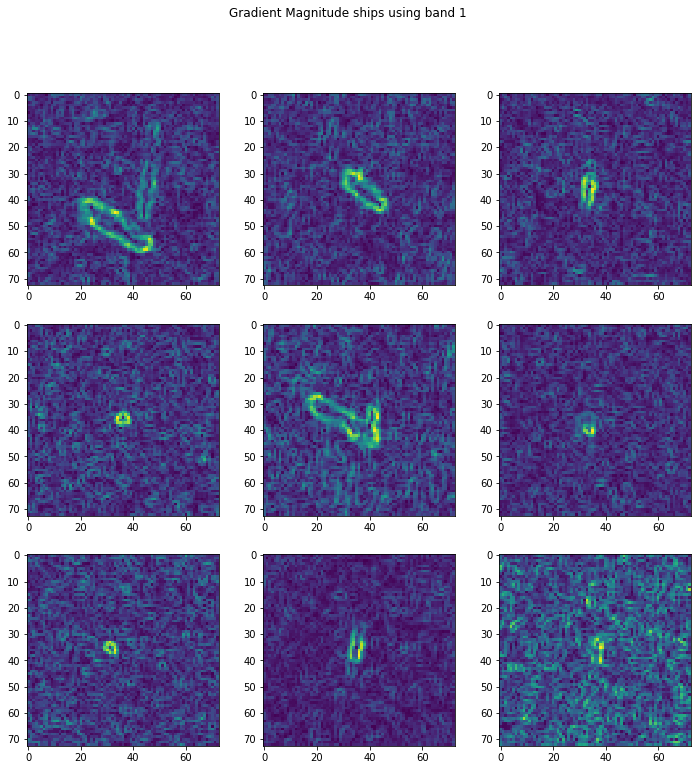

In [25]:
# Plot band_1
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry))
fig.suptitle('Gradient Magnitude ships using band 1')
    
plt.show()

#### Second Derivatives
簡単な二階微分演算子を定義することもできます。 3x3の2次導関数は、3x3の1次導関数よりも平滑化が少ないため、信号と背景の間のコントラストが低くなる可能性があります。

In [26]:
# kernel
xder2 = np.array([[-1,2,-1],[-3,6,-3],[-1,2,-1]])

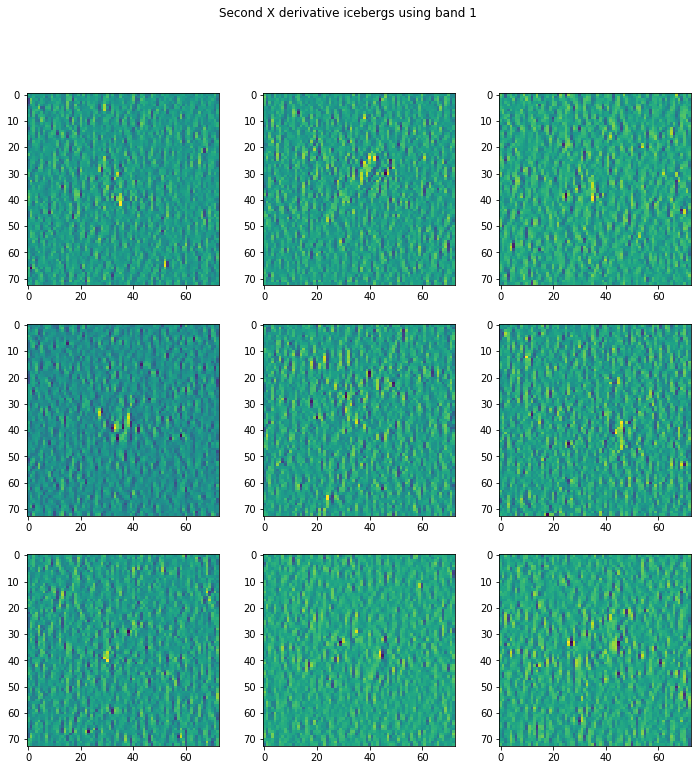

In [27]:
# Plot band_1
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder2,mode='valid')
    ax.imshow(arr)
fig.suptitle('Second X derivative icebergs using band 1')
    
plt.show()

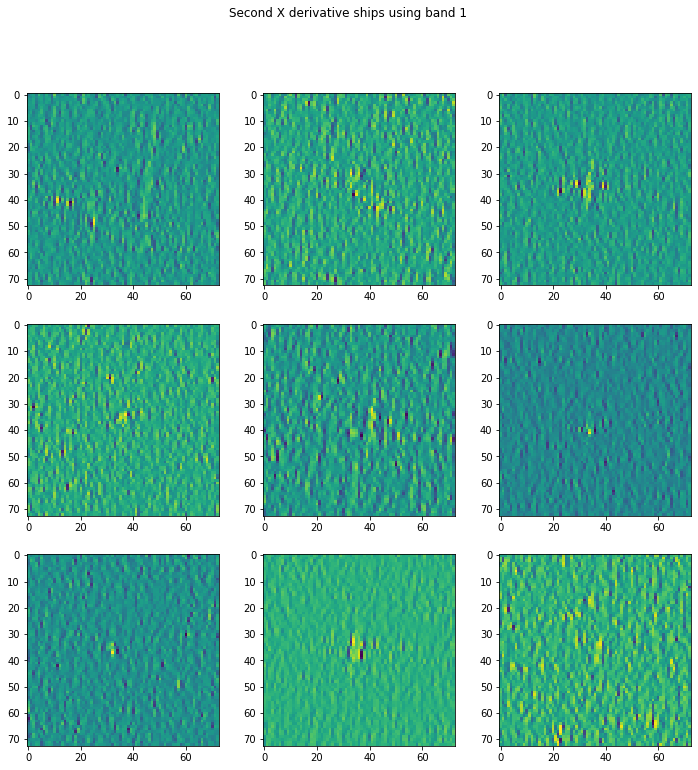

In [28]:
# Plot band_1
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder2,mode='valid')
    ax.imshow(arr)
fig.suptitle('Second X derivative ships using band 1')
    
plt.show()

ここでは、信号が明確ではないことがわかります。 船は少し目立ちますが、平滑化を行わないと、ノイズがここでかなり問題になるように見えます。

#### Laplacian
ラプラシアン演算子は、2次導関数の合計、または勾配の発散です。

In [29]:
# kernel
yder2 = np.array([[-1,-3,-1],[2,6,2],[-1,-3,-1]])

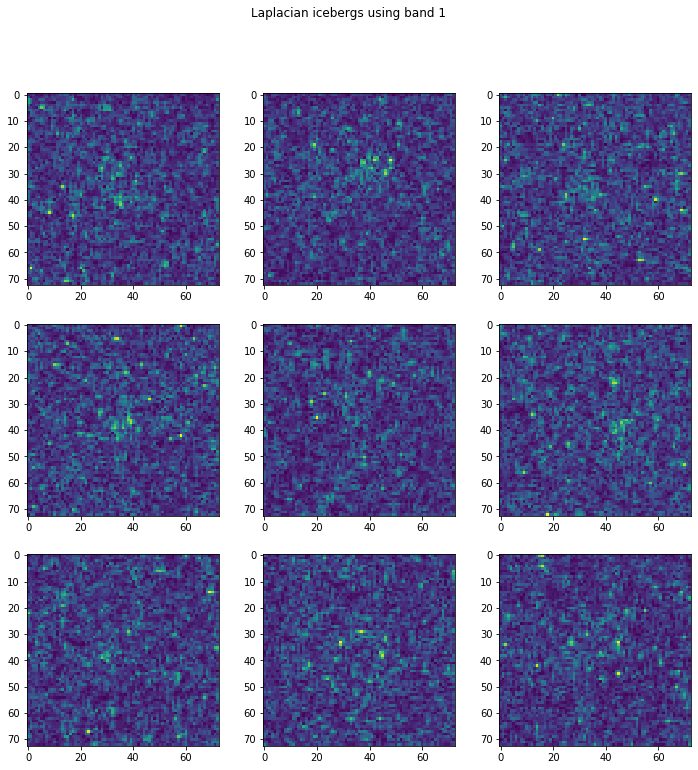

In [30]:
# Plot band_1
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder2,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),yder2,mode='valid')

    ax.imshow(np.hypot(arrx,arry))
fig.suptitle('Laplacian icebergs using band 1')
    
plt.show()

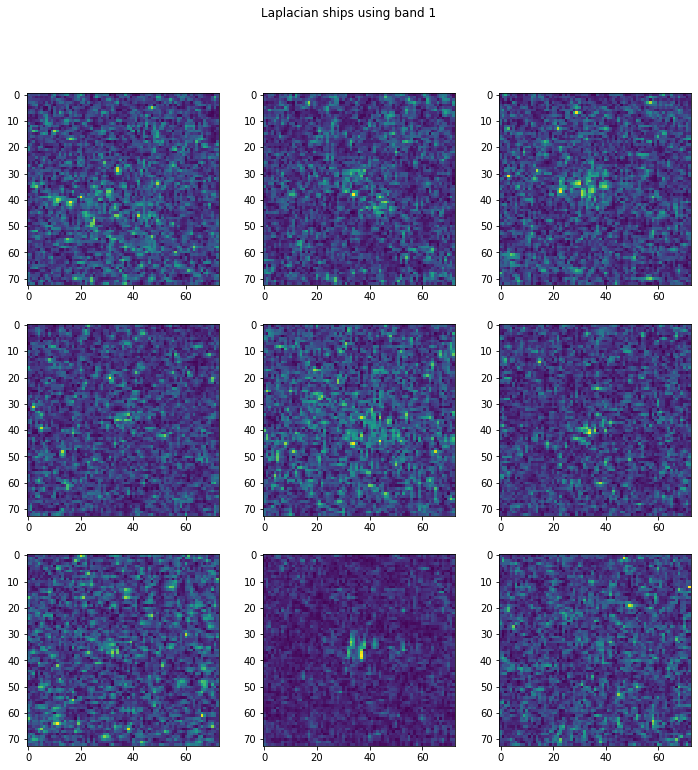

In [31]:
# Plot band_1
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder2,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),yder2,mode='valid')

    ax.imshow(np.hypot(arrx,arry))
fig.suptitle('Laplacian ships using band 1')
    
plt.show()

ラプラシアン画像に興味深い垂直線と水平線の特徴が見られますが、信号を確認して多くの小さなクラスターに分割することはほとんど困難です。この場合も、2次導関数を使用するには、平滑化が必要になる可能性があります。

#### Magnitude of the Curl of Gradient
私たちが見ることができる他の多くのものがあります。 最後に行うのは、グラデーションのカールの大きさです。 微分可能な関数の場合、これは実際には正確に0であると想定されますが、離散画像の場合、これはおそらく当てはまりません。 しかし、これが役立つとは思いません。

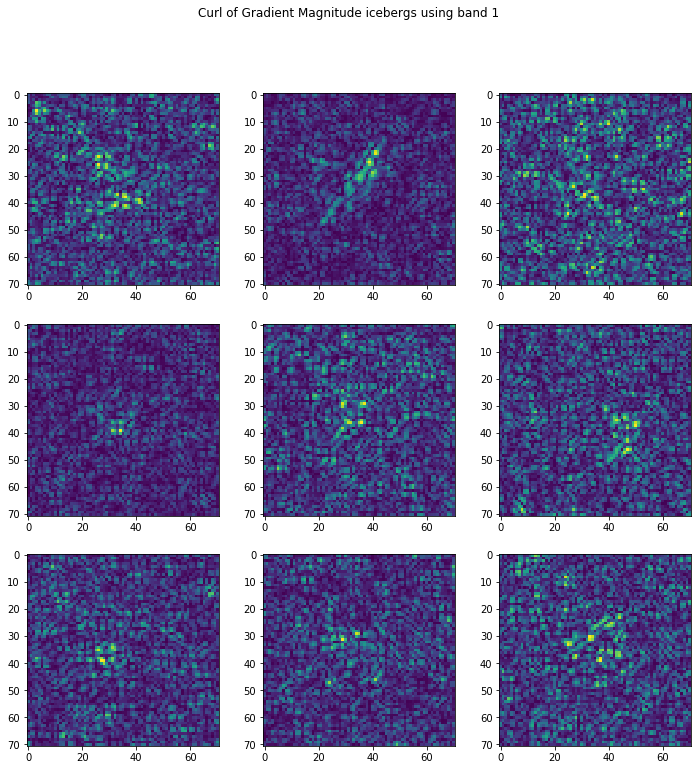

In [32]:
# Plot band_1
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),yder,mode='valid')
    arrx = signal.convolve2d(arrx,yder,mode='valid')
    arry = signal.convolve2d(arry,xder,mode='valid')
    ax.imshow(np.hypot(arrx,arry))
fig.suptitle('Curl of Gradient Magnitude icebergs using band 1')
    
plt.show()

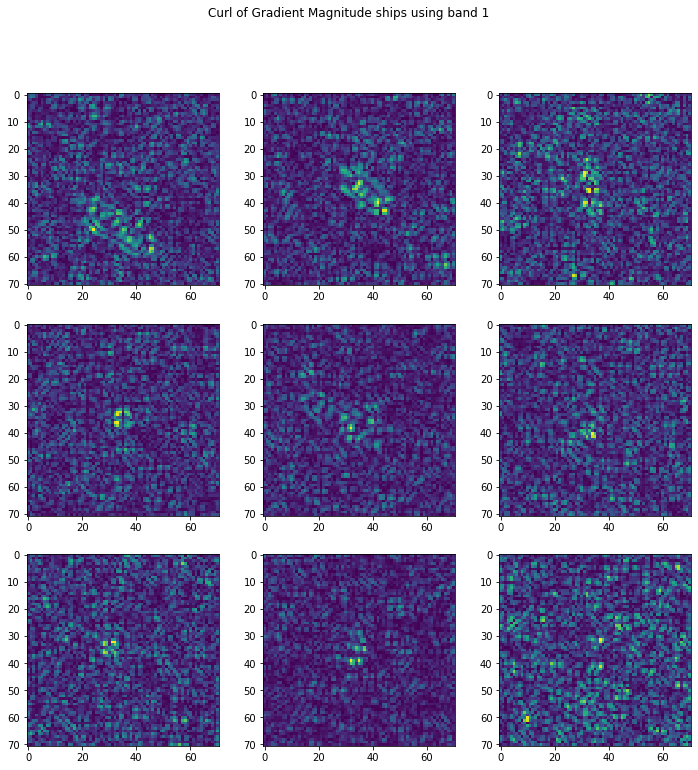

In [33]:
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),yder,mode='valid')
    arrx = signal.convolve2d(arrx,yder,mode='valid')
    arry = signal.convolve2d(arry,xder,mode='valid')
    ax.imshow(np.hypot(arrx,arry))
fig.suptitle('Curl of Gradient Magnitude ships using band 1')
    
plt.show()

予想どおり、せいぜい有用性が限られていることがわかります。 ただし、見栄えの良い画像がいくつか得られます。 小さなタイルがいくつか並んでいます。 分析に役立たない場合でも、この特定の変換を使用して画像を変換することにより、いくつかの素晴らしいテクスチャを取得します。

#### Conclusions
画像からいくつかのグローバルな特徴を構築しましたが、氷山と船の間だけでもいくつかの顕著な違いがあることがわかりました。 ただし、グローバル統計のみに基づいた分類子はあまり効果的ではないと思います。

また、画像のいくつかの変換についても見てきました。 エッジ検出（勾配）ベースの方法は、いくつかの優れた機能を備えているようであり、平滑化は、信号サイズが小さい画像で役立つ場合があります。